In [1]:
import sys
import os
import cv2
import numpy as np
import tensorflow
import keras
import keras, keras.layers as L
sys.path.append("..")
from keras.datasets import cifar10

tf.estimator package not installed.
tf.estimator package not installed.


Using TensorFlow backend.


In [2]:
#Load images
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(cv2.imread(f))
            labels.append(int(d))
    return images, labels
ROOT_PATH = ""
train_data_directory = os.path.join(ROOT_PATH, "Training")
test_data_directory = os.path.join(ROOT_PATH, "Testing")


x_train, y_train = load_data(train_data_directory)
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test, y_test = load_data(test_data_directory)
x_test = np.array(x_test)
y_test = np.array(y_test)
#Preprocess
x_test = [cv2.resize(image, (28, 28)) for image in x_test]
x_train = [cv2.resize(image, (28, 28)) for image in x_train]
x_test = np.array(x_test)
x_train = np.array(x_train)

y_train = np.reshape(y_train,[y_train.shape[0],1])
y_test = np.reshape(y_test,[y_test.shape[0],1])



In [3]:
import matplotlib.pyplot as plt

IMG_SHAPE = x_train[0].shape
plt.title('sample images')

plt.imshow(x_test[7])



In [6]:
def build_deep_autoencoder(img_shape,code_size=32):
    """PCA's deeper brother. See instructions above"""
    H,W,C = img_shape
    NFILTERS=16
    N1=256

    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.normalization.BatchNormalization(axis=1))
    
    #Convolutions
    encoder.add(L.Conv2D(filters=NFILTERS*2,kernel_size=3,padding="same"))
    encoder.add(L.advanced_activations.LeakyReLU())
    encoder.add(L.Conv2D(filters=NFILTERS,kernel_size=3,padding="same"))
    encoder.add(L.advanced_activations.LeakyReLU())
    encoder.add(L.MaxPooling2D())

    
    encoder.add(L.Flatten()) 
    
    encoder.add(L.Dense(N1))
    encoder.add(L.advanced_activations.LeakyReLU())
    encoder.add(L.normalization.BatchNormalization())
    encoder.add(L.Dense(N1))
    encoder.add(L.advanced_activations.LeakyReLU())
    encoder.add(L.normalization.BatchNormalization())    
    
    encoder.add(L.Dense(code_size))
   
    
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.normalization.BatchNormalization())
    
    decoder.add(L.Dense(N1))
    decoder.add(L.advanced_activations.LeakyReLU())
    decoder.add(L.normalization.BatchNormalization())
    decoder.add(L.Dense(N1))
    decoder.add(L.advanced_activations.LeakyReLU())
    decoder.add(L.normalization.BatchNormalization())   
    
    
    decoder.add(L.Dense(np.prod(img_shape)//4))
    decoder.add(L.advanced_activations.LeakyReLU()) 
    decoder.add(L.normalization.BatchNormalization()) 
    decoder.add(L.Reshape((H//2,W//2,C)))   
    decoder.add(L.UpSampling2D())

    decoder.add(L.Deconv2D(filters=NFILTERS,kernel_size=3,padding="same"))
    decoder.add(L.advanced_activations.LeakyReLU())
    decoder.add(L.Deconv2D(filters=NFILTERS*2,kernel_size=3,padding="same")) 
    
    encoder.add(L.advanced_activations.LeakyReLU())
    decoder.add(L.Deconv2D(filters=3,kernel_size=3,padding="same"))

    
    return encoder,decoder

In [14]:
encoder,decoder = build_deep_autoencoder(IMG_SHAPE,code_size=32)

In [15]:
#autoencoder training
#Can also use this for image segmentation. need to change y in autoencoder.fit(x=..., y=...,....). y will take as
#argument manually segmented images. Also could work for denoising.
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_8 (Batch (None, 28, 28, 3)         112       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 16)        4624      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
__________

In [20]:
autoencoder.compile('nadam','mse')
autoencoder.fit(x=x_train,y=x_train,epochs=50,
                    validation_data=[x_test,x_test])

Train on 4575 samples, validate on 2520 samples
Epoch 1/50
4575/4575 [==============================] - 40s 9ms/step - loss: 1698.5020 - val_loss: 1911.2115
Epoch 2/50
4575/4575 [==============================] - 37s 8ms/step - loss: 1649.1530 - val_loss: 1423.7958
Epoch 3/50
4575/4575 [==============================] - 37s 8ms/step - loss: 1596.0968 - val_loss: 1383.2622
Epoch 4/50
4575/4575 [==============================] - 36s 8ms/step - loss: 1536.2630 - val_loss: 1374.1314
Epoch 5/50
4575/4575 [==============================] - 45s 10ms/step - loss: 1511.1626 - val_loss: 1495.0632
Epoch 6/50
4575/4575 [==============================] - 42s 9ms/step - loss: 1477.2428 - val_loss: 1302.2197
Epoch 7/50
4575/4575 [==============================] - 38s 8ms/step - loss: 1426.2933 - val_loss: 1470.7579
Epoch 8/50
4575/4575 [==============================] - 36s 8ms/step - loss: 1394.3774 - val_loss: 1252.4440
Epoch 9/50
4575/4575 [==============================] - 36s 8ms/step - loss: 13

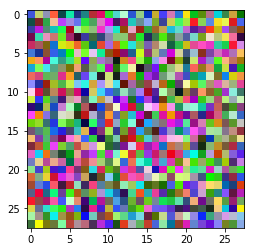

In [31]:
images = x_train
codes = encoder.predict(images)
reconstructed = decoder.predict(codes)
plt.imshow(reconstructed[6])

In [24]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)


def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

/Users/bedabratachoudhury/anaconda2/lib/python2.7/site-packages/sklearn/neighbors/approximate.py:258: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


In [25]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

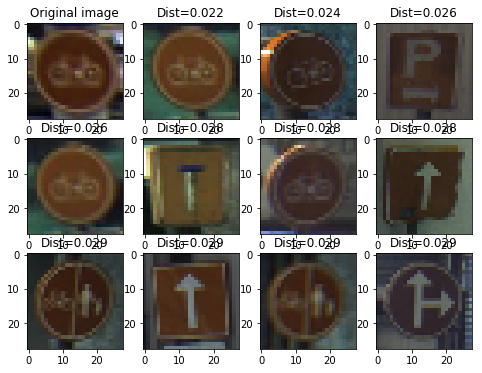

In [28]:
import matplotlib.pyplot as plt
show_similar(x_test[100])
plt.show()